In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install torchsummary
!pip install split-folders

In [4]:
# Import essential libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
import pathlib
import splitfolders
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [5]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available:",torch.cuda.get_device_name(0) )
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available: Tesla T4


In [6]:
labels_df = pd.read_csv('/kaggle/input/brian-tumor-dataset/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


# Loading Dataset

In [7]:
# Dataset Path
data_dir = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = './brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:42, 107.88 files/s]


In [8]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [9]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("./train"), transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("./val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [10]:
for x,y in val_set:
    print(x,y)
    break

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [11]:
for x,y in train_set:
    print(x,y)
    break

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# Visualisation

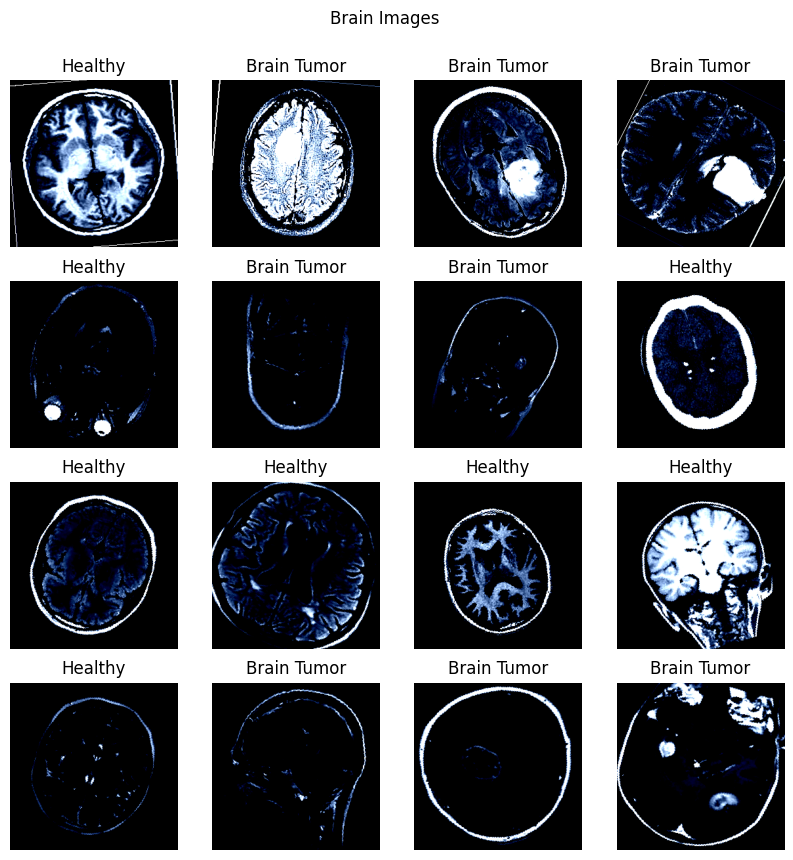

In [12]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [13]:
print(len(train_set), len(val_set))

3679 921


In [14]:
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [15]:
for x,y in train_loader:
    print(x,y)
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [16]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



# Neural Networks

In [17]:
class CNN_TUMOR(nn.Module):

    def __init__(self):
        super().__init__()
        # Convolution Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3) 
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.conv4_bn = nn.BatchNorm2d(256)

        
        # given only 2 Layers 
        self.fc1 = nn.Linear(14*14*256, 100) # Fully Connected Layers
        self.fc1_bn = nn.BatchNorm1d(100)

        self.fc2 = nn.Linear(100, 100) #hidden layer
        self.fc2_bn = nn.BatchNorm1d(100)

        self.fc3 = nn.Linear(100, 2)# can work with multiclass also

    def forward(self,X):
        #print(X.shape)
        # cnn+relu -> pooling layer -> cnn+relu -> pooling layer-> cnn+relu -> pooling layer->flatten->input layers ANN->Hidden layeers-> output classes
        X = F.relu(self.conv1(X)); 
        X = self.conv1_bn(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.dropout(X, 0.25)  
        #print(X.shape)


        X = F.relu(self.conv2(X))
        X = self.conv2_bn(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.dropout(X, 0.25) 
        #print(X.shape)

        X = F.relu(self.conv3(X))
        X = self.conv3_bn(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.dropout(X, 0.25) 
        #print(X.shape)

        X = F.relu(self.conv4(X))
        X = self.conv4_bn(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.dropout(X, 0.25)  
        
        #print(X.shape) 
        X = X.view(-1, 14*14*256)# flatten to pass it to the fully connected layers

        X = F.relu(self.fc1(X)) 
        X = self.fc1_bn(X)
        X = F.dropout(X, 0.25) 

        X = F.relu(self.fc2(X)) 
        X = self.fc2_bn(X)
        X = F.dropout(X, 0.25) 

        X = self.fc3(X)
        return F.softmax(X) # we need probabilties of each class so use softmax#
    
model = CNN_TUMOR()

In [18]:
model.to(device)

CNN_TUMOR(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=100, bias=True)
  (fc1_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc2_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=2, bias

In [19]:
lossfun = nn.CrossEntropyLoss() # BCEWithLogitsLoss() if we would have one output by ANN layer
#also we would have u used different accuracy formula and no softmax layer

optimizer = optim.Adam(model.parameters(), lr=3e-4)



In [20]:
# or
# lossfunc = nn.NLLLoss(reduction="sum") with last layer as F.log_softmax(X, dim=1)

In [21]:
# Model Summary for CNN Model
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]             896
       BatchNorm2d-2         [-1, 32, 254, 254]              64
            Conv2d-3         [-1, 64, 125, 125]          18,496
       BatchNorm2d-4         [-1, 64, 125, 125]             128
            Conv2d-5          [-1, 128, 60, 60]          73,856
       BatchNorm2d-6          [-1, 128, 60, 60]             256
            Conv2d-7          [-1, 256, 28, 28]         295,168
       BatchNorm2d-8          [-1, 256, 28, 28]             512
            Linear-9                  [-1, 100]       5,017,700
      BatchNorm1d-10                  [-1, 100]             200
           Linear-11                  [-1, 100]          10,100
      BatchNorm1d-12                  [-1, 100]             200
           Linear-13                    [-1, 2]             202
Total params: 5,417,778
Trainable param

# Train the model

In [ ]:
epochs = 60

trainAcc = []
trainLoss = []

testAcc = []
testLoss = []


for epochi in tqdm(range(epochs)):

    model.train()  #start training od model
    batch_loss=0.0 
    batch_acc=0.0

    for X, y in train_loader:  ## for 1 epoch this willl run 33 times u can check below cells or run the loop seperately
        X, y = X.to(device), y.to(device)   

        output = model(X)
        loss = lossfun(output, y)
        pred = torch.max(output.data, 1)[1]
        acc=((pred == y).sum()).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss+=loss.item()        # update running loss
        batch_acc+=acc   

    losses=batch_loss/float(len(train_loader.dataset))  # average loss value
    accuracy=batch_acc/float(len(train_loader.dataset)) # average metric value
    # collect losses
    trainLoss.append(losses)
    trainAcc.append(accuracy)



    model.eval() # start evaluation
    test_batch_loss=0.0 
    test_batch_acc=0.0
    with torch.no_grad():  # is also in epoch loop
        for X_test, y_test in val_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)   
            output = model(X_test)
            loss = lossfun(output, y_test)

            pred = torch.max(output.data, 1)[1]
            acc=((pred == y_test).sum()).item()

            test_batch_loss+=loss.item()        # update running loss
            test_batch_acc+=acc


        test_losses=test_batch_loss/float(len(val_loader.dataset))  # average loss value
        test_accuracy=test_batch_acc/float(len(val_loader.dataset)) # average metric value
        # collect losses
        testLoss.append(test_losses)
        testAcc.append(test_accuracy)


    print("Epoch:", epochi, "trainAcc: ", "{:.5f}".format(trainAcc[epochi]),  "trainLoss: ", "{:.5f}".format(trainLoss[epochi]),  "testAcc: ", "{:.5f}".format(testAcc[epochi]),  "testLoss: ","{:.5f}".format(testLoss[epochi]) )


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0 trainAcc:  0.75564 trainLoss:  0.00867 testAcc:  0.80130 testLoss:  0.00834
Epoch: 1 trainAcc:  0.82522 trainLoss:  0.00765 testAcc:  0.81542 testLoss:  0.00817
Epoch: 2 trainAcc:  0.84942 trainLoss:  0.00730 testAcc:  0.83713 testLoss:  0.00761
Epoch: 3 trainAcc:  0.87497 trainLoss:  0.00698 testAcc:  0.88708 testLoss:  0.00707
Epoch: 4 trainAcc:  0.89291 trainLoss:  0.00665 testAcc:  0.89142 testLoss:  0.00686
Epoch: 5 trainAcc:  0.90786 trainLoss:  0.00643 testAcc:  0.89794 testLoss:  0.00683
Epoch: 6 trainAcc:  0.91384 trainLoss:  0.00630 testAcc:  0.93051 testLoss:  0.00646
Epoch: 7 trainAcc:  0.92416 trainLoss:  0.00619 testAcc:  0.91422 testLoss:  0.00638
Epoch: 8 trainAcc:  0.93096 trainLoss:  0.00605 testAcc:  0.86319 testLoss:  0.00724
Epoch: 9 trainAcc:  0.92987 trainLoss:  0.00604 testAcc:  0.93377 testLoss:  0.00618
Epoch: 10 trainAcc:  0.93884 trainLoss:  0.00596 testAcc:  0.94028 testLoss:  0.00613
Epoch: 11 trainAcc:  0.94564 trainLoss:  0.00581 testAcc:  0.941

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation loss on the first subplot
ax1.plot(trainLoss, marker='o', linestyle='-', color='b', label='Training Loss')
ax1.plot(testLoss, marker='x', linestyle='--', color='r', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.legend()
ax1.grid(True)

# Plot the training and validation accuracy on the second subplot
ax2.plot(trainAcc, marker='o', linestyle='-', color='b', label='Training Accuracy')
ax2.plot(testAcc, marker='x', linestyle='--', color='r', label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Over Epochs')
ax2.legend()
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

# Testing

In [ ]:
# testing complete dataset
yTrue= []
yPred= []
testAcc = []
testLoss = []
with torch.no_grad():  # is also in epoch loop
    for X_test, y_test in val_loader :
        X_test, y_test = X_test.to(device), y_test.to(device)   
        output = model(X_test)
        loss = lossfun(output, y_test)

        pred = torch.max(output.data, 1)[1]
        acc=((pred == y_test).sum()).item()

        test_batch_loss+=loss.item()        # update running loss
        test_batch_acc+=acc

        for x in y_test:
            yTrue.append(x.item())
        for x in pred:
            yPred.append(x.item())
    test_losses=test_batch_loss/float(len(val_loader.dataset))  # average loss value
    test_accuracy=test_batch_acc/float(len(val_loader.dataset)) # average metric value
    # collect losses
    testLoss.append(test_losses*100)
    testAcc.append(test_accuracy*100)

In [ ]:
# yTrue, yPred

In [ ]:
cm = confusion_matrix(yTrue, yPred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = ['0.0', '1.0']
print(classification_report(yTrue, yPred, target_names=target_names))

# Fine Tune # Resnet Architecture

In [ ]:
import torchvision.models as models
resnet_model = models.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features # modify last layer
resnet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 100),
    nn.BatchNorm1d(100),
    nn.Linear(100, 2),
    nn.Softmax()  # Add softmax layer # is necessary becaue we want to output classes =2 so we want prob and accuracy formula is used is also according to softmax which deals with more than one class
)

resnet_model.to(device)


In [ ]:
# Model Summary for CNN Model
summary(resnet_model, input_size=(3, 256, 256))

In [ ]:
lossfun = nn.CrossEntropyLoss() # BCEWithLogitsLoss() if we would have one output by ANN layer
#also we would have u used different accuracy formula and no softmax layer

optimizer = optim.Adam(resnet_model.parameters(), lr=0.0003)



# Train with Resnet

In [ ]:
epochs = 10

trainAcc = []
trainLoss = []

testAcc = []
testLoss = []


for epochi in tqdm(range(epochs)):

    resnet_model.train()  #start training od model
    batch_loss=0.0 
    batch_acc=0.0

    for X, y in train_loader:  ## for 1 epoch this willl run 33 times u can check below cells or run the loop seperately
        X, y = X.to(device), y.to(device)   

        output = resnet_model(X)
        loss = lossfun(output, y)
        pred = torch.max(output.data, 1)[1]
        acc=((pred == y).sum()).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss+=loss.item()        # update running loss
        batch_acc+=acc   

    losses=batch_loss/float(len(train_loader.dataset))  # average loss value
    accuracy=batch_acc/float(len(train_loader.dataset)) # average metric value
    # collect losses
    trainLoss.append(losses)
    trainAcc.append(accuracy)



    resnet_model.eval() # start evaluation
    test_batch_loss=0.0 
    test_batch_acc=0.0
    with torch.no_grad():  # is also in epoch loop
        for X_test, y_test in val_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)   
            output = resnet_model(X_test)
            loss = lossfun(output, y_test)

            pred = torch.max(output.data, 1)[1]
            acc=((pred == y_test).sum()).item()

            test_batch_loss+=loss.item()        # update running loss
            test_batch_acc+=acc


        test_losses=test_batch_loss/float(len(val_loader.dataset))  # average loss value
        test_accuracy=test_batch_acc/float(len(val_loader.dataset)) # average metric value
        # collect losses
        testLoss.append(test_losses)
        testAcc.append(test_accuracy)


    print("Epoch:", epochi, "trainAcc: ", "{:.5f}".format(trainAcc[epochi]),  "trainLoss: ", "{:.5f}".format(trainLoss[epochi]),  "testAcc: ", "{:.5f}".format(testAcc[epochi]),  "testLoss: ","{:.5f}".format(testLoss[epochi]) )


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation loss on the first subplot
ax1.plot(trainLoss, marker='o', linestyle='-', color='b', label='Training Loss')
ax1.plot(testLoss, marker='x', linestyle='--', color='r', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.legend()
ax1.grid(True)

# Plot the training and validation accuracy on the second subplot
ax2.plot(trainAcc, marker='o', linestyle='-', color='b', label='Training Accuracy')
ax2.plot(testAcc, marker='x', linestyle='--', color='r', label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Over Epochs')
ax2.legend()
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()